In [1]:
#from helper_functions import get_llm_response, print_llm_response, display_table
from IPython.display import Markdown, display, HTML
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [2]:
# loading the various datasets
# account 
df_account = pd.read_csv("accounts.csv")

# products
df_product = pd.read_csv("products.csv")

# sales pipeline
df_sales_pipeline = pd.read_csv("sales_pipeline.csv")

# products
df_sales_teams = pd.read_csv("sales_teams.csv")

print(df_product.head())
print(df_account.head())
print(df_sales_teams.head())
print(df_sales_pipeline.head())

        product series  sales_price
0     GTX Basic    GTX          550
1       GTX Pro    GTX         4821
2    MG Special     MG           55
3   MG Advanced     MG         3393
4  GTX Plus Pro    GTX         5482
            account     sector  year_established  revenue  employees  \
0  Acme Corporation  technolgy              1996  1100.04       2822   
1        Betasoloin    medical              1999   251.41        495   
2          Betatech    medical              1986   647.18       1185   
3        Bioholding    medical              2012   587.34       1356   
4           Bioplex    medical              1991   326.82       1016   

  office_location subsidiary_of  
0   United States           NaN  
1   United States           NaN  
2           Kenya           NaN  
3      Philipines           NaN  
4   United States           NaN  
         sales_agent           manager regional_office
0      Anna Snelling  Dustin Brinkmann         Central
1     Cecily Lampkin  Dustin Brinkman

In [3]:
# merge the datasets
temp = df_sales_pipeline.merge(df_sales_teams, how='left', on='sales_agent') # merge sales pipeline and sales teams
temp = temp.merge(df_product, how='left', on='product') # merge product 
all_df = temp.merge(df_account, how='left', on='account') # merge account

In [4]:
def perform_eda(data, target_column=None, num_bins=20):
    """
    Performs exploratory data analysis (EDA) on a dataset.

    Args:
        data (pd.DataFrame): The dataset to analyze.
        target_column (str, optional): Name of the target column for analysis. Defaults to None.
        num_bins (int, optional): Number of bins for histograms. Defaults to 20.

    Returns:
        None: Displays EDA results including statistics, distributions, and visualizations.
    """
    print("===== EDA Summary =====\n")
    
    # 1. Basic Information
    print("1. Basic Information:")
    print(f"Shape of dataset: {data.shape}")
    print("\nData Types:\n", data.dtypes)
    print("\nSample Data:\n", data.head(), "\n")

    # 2. Check for Missing Values
    print("2. Missing Values:")
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0], "\n")
    else:
        print("No missing values detected.\n")
    
    # 3. Summary Statistics
    print("3. Summary Statistics:")
    print(data.describe(include='all'), "\n")

    # 4. Target Column Analysis
    if target_column and target_column in data.columns:
        print(f"4. Target Column Analysis: {target_column}")
        if data[target_column].dtype == 'object':
            # If the target column is categorical
            print("\nValue Counts:\n", data[target_column].value_counts(), "\n")
            try:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=target_column, data=data, order=data[target_column].value_counts().index)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()  # Adjust layout to prevent overlap
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
        elif data[target_column].dtype in ['int64', 'float64']:
            # If the target column is numeric (int64 or float64)
            try:
                sns.histplot(data[target_column], kde=True, bins=num_bins)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
    else:
        print("No target column specified or invalid target column.")

    # 5. Visualizations for Numeric Features
    print("5. Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        try:
            data[numeric_columns].hist(figsize=(12, 8), bins=num_bins)
            plt.suptitle("Numeric Feature Distributions", fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting numeric distributions: {e}")
    else:
        print("No numeric column found to plot")

    # 6. Correlation Heatmap
    print("6. Correlation Analysis:")
    if len(numeric_columns) > 0:
        try:
            correlation_matrix = data[numeric_columns].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap: {e}")
    else:
        print("No numeric column found to perform correlation")

    # 7. Categorical Feature Analysis
    print("7. Categorical Features:")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            try:
                print(f"\nValue Counts for {column}:\n", data[column].value_counts())
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=data, order=data[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {e}")
    else:
        print("No categorical features found.")

    print("\n===== EDA Complete =====")


===== EDA Summary =====

1. Basic Information:
Shape of dataset: (8800, 18)

Data Types:
 opportunity_id       object
sales_agent          object
product              object
account              object
deal_stage           object
engage_date          object
close_date           object
close_value         float64
manager              object
regional_office      object
series               object
sales_price         float64
sector               object
year_established    float64
revenue             float64
employees           float64
office_location      object
subsidiary_of        object
dtype: object

Sample Data:
   opportunity_id      sales_agent         product  account deal_stage  \
0       1C1I7A6R      Moses Frase  GTX Plus Basic  Cancity        Won   
1       Z063OYW0  Darcel Schlecht          GTXPro    Isdom        Won   
2       EC4QE1BX  Darcel Schlecht      MG Special  Cancity        Won   
3       MV1LWRNH      Moses Frase       GTX Basic  Codehow        Won   
4       PE84

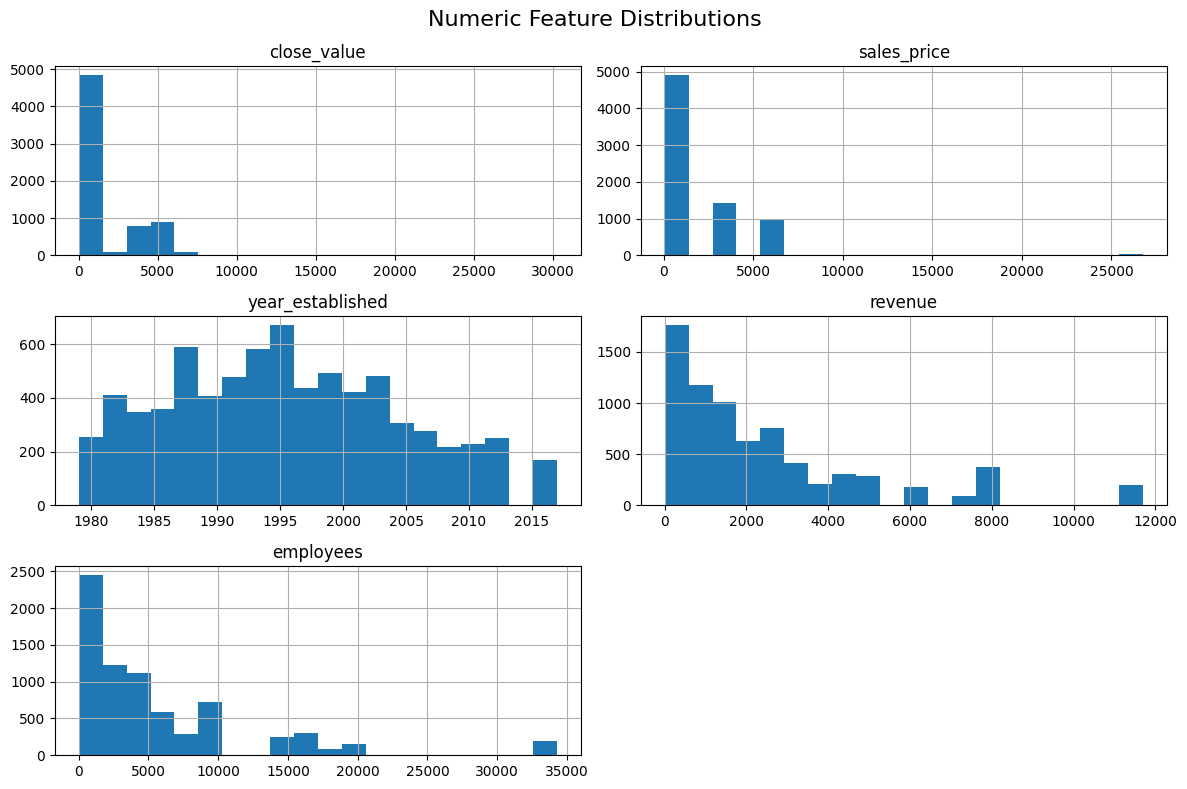

6. Correlation Analysis:


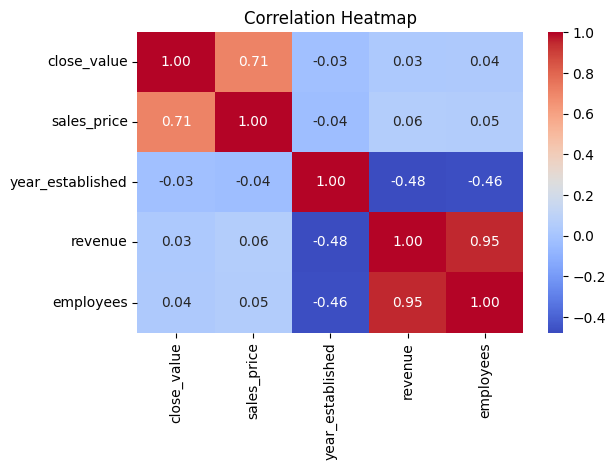

7. Categorical Features:

Value Counts for opportunity_id:
 opportunity_id
KAZ72JJ0    1
AV50UWVV    1
SH4FSTJV    1
KIOF5EM0    1
Q5RRTVJK    1
           ..
PE84CX4O    1
MV1LWRNH    1
EC4QE1BX    1
Z063OYW0    1
1C1I7A6R    1
Name: count, Length: 8800, dtype: int64


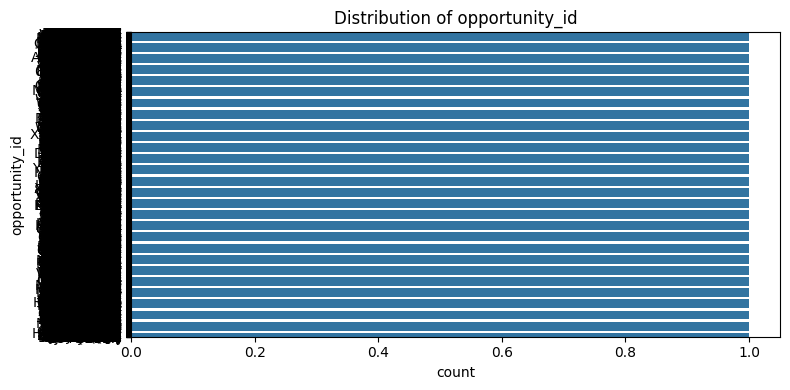


Value Counts for sales_agent:
 sales_agent
Darcel Schlecht       747
Vicki Laflamme        451
Anna Snelling         448
Kary Hendrixson       438
Kami Bicknell         362
Versie Hillebrand     361
Zane Levy             349
Cassey Cress          346
Jonathan Berthelot    345
Gladys Colclough      317
Lajuana Vencill       311
Corliss Cosme         310
Markita Hansen        306
Maureen Marcano       285
Marty Freudenburg     281
Donn Cantrell         275
James Ascencio        267
Violet Mclelland      261
Moses Frase           260
Daniell Hammack       259
Niesha Huffines       239
Reed Clapper          237
Boris Faz             210
Cecily Lampkin        203
Hayden Neloms         202
Elease Gluck          177
Rosalina Dieter       160
Rosie Papadopoulos    160
Garret Kinder         123
Wilburn Farren        110
Name: count, dtype: int64


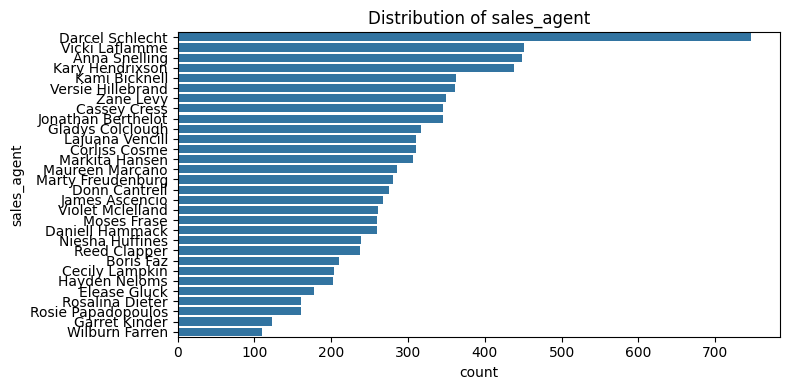


Value Counts for product:
 product
GTX Basic         1866
MG Special        1651
GTXPro            1480
MG Advanced       1412
GTX Plus Basic    1383
GTX Plus Pro       968
GTK 500             40
Name: count, dtype: int64


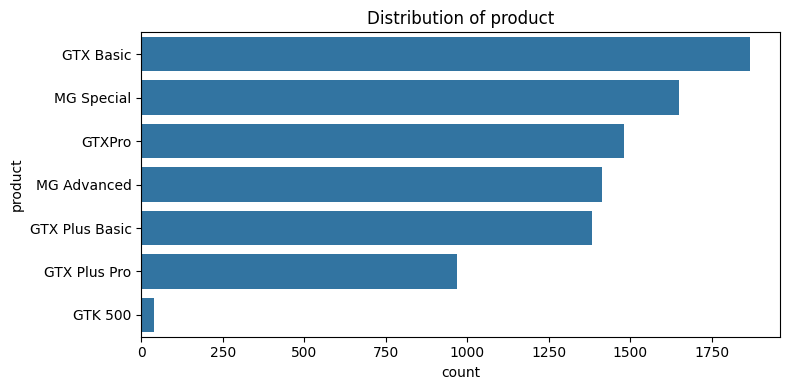


Value Counts for account:
 account
Hottechi                 200
Kan-code                 196
Konex                    178
Condax                   170
Dontechi                 129
                        ... 
Newex                     55
Bioplex                   53
The New York Inquirer     52
Sumace                    52
Iselectrics               51
Name: count, Length: 85, dtype: int64


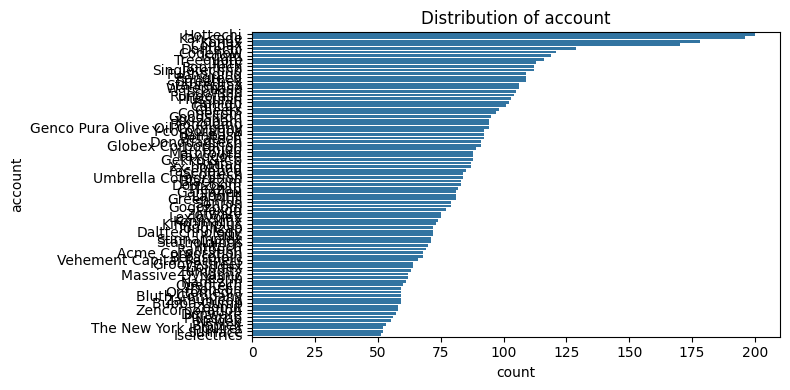


Value Counts for deal_stage:
 deal_stage
Won            4238
Lost           2473
Engaging       1589
Prospecting     500
Name: count, dtype: int64


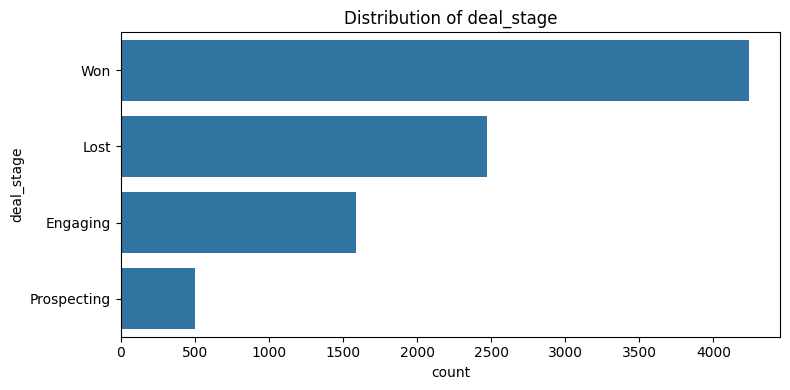


Value Counts for engage_date:
 engage_date
2017-07-22    66
2017-07-21    60
2017-07-30    56
2017-07-25    54
2017-07-19    52
              ..
2016-10-30     1
2016-11-18     1
2016-11-15     1
2017-12-23     1
2017-12-26     1
Name: count, Length: 421, dtype: int64


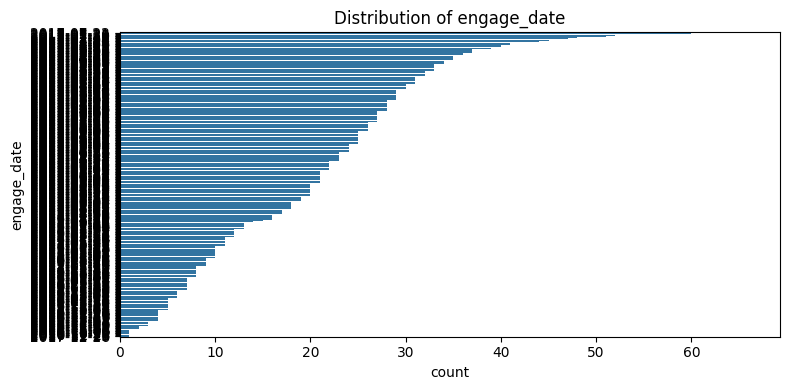


Value Counts for close_date:
 close_date
2017-05-22    41
2017-06-11    36
2017-05-26    34
2017-11-19    34
2017-05-20    34
              ..
2017-10-06    12
2017-10-01    12
2017-07-22    11
2017-04-26    10
2017-07-20     5
Name: count, Length: 306, dtype: int64


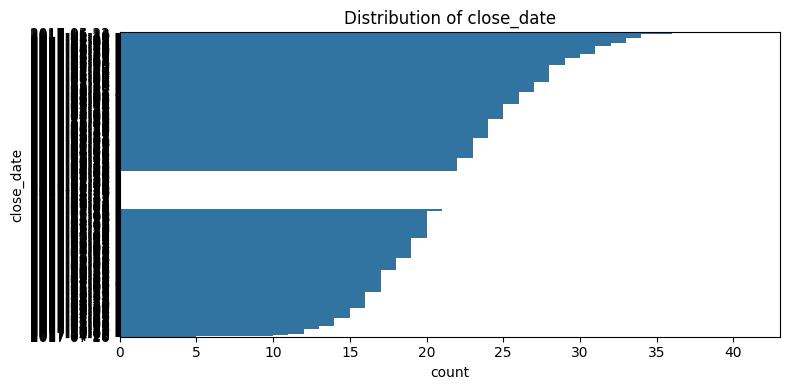


Value Counts for manager:
 manager
Melvin Marxen       1929
Summer Sewald       1701
Dustin Brinkmann    1583
Rocco Neubert       1327
Celia Rouche        1296
Cara Losch           964
Name: count, dtype: int64


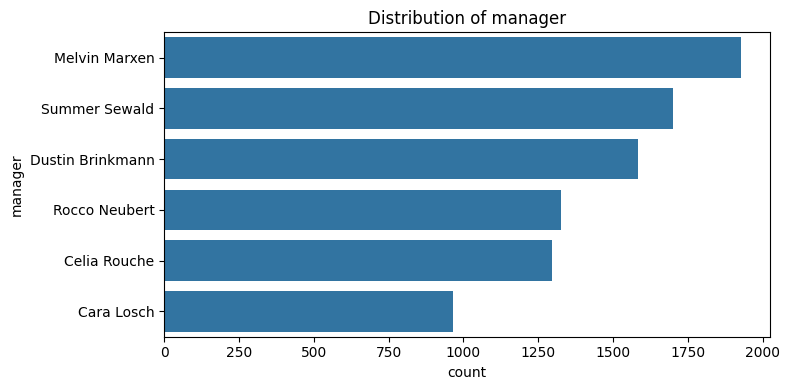


Value Counts for regional_office:
 regional_office
Central    3512
West       2997
East       2291
Name: count, dtype: int64


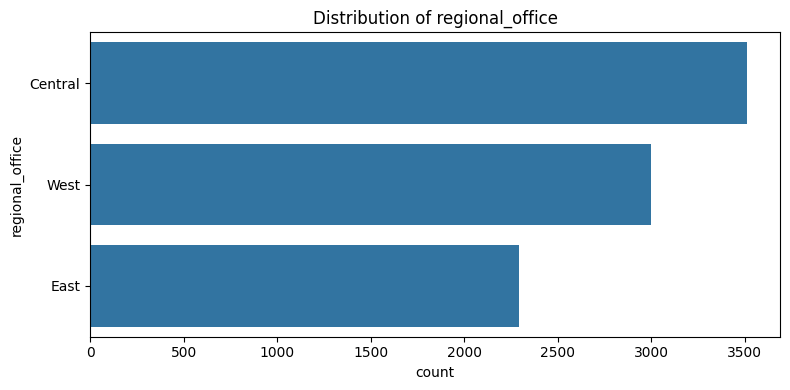


Value Counts for series:
 series
GTX    4217
MG     3063
GTK      40
Name: count, dtype: int64


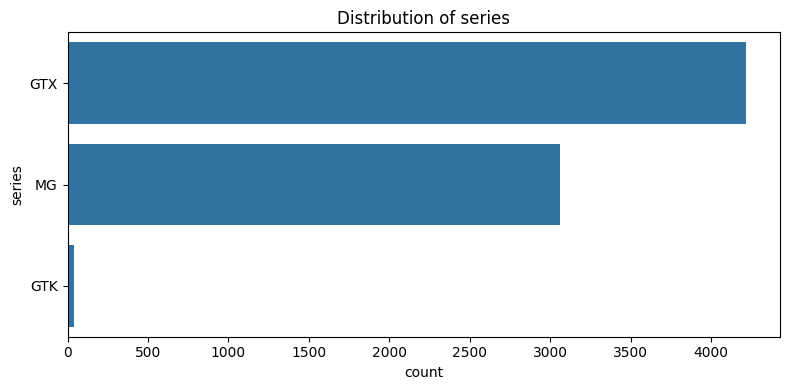


Value Counts for sector:
 sector
retail                1397
technolgy             1165
medical               1051
software               757
finance                678
marketing              674
telecommunications     501
entertainment          451
services               390
employment             311
Name: count, dtype: int64


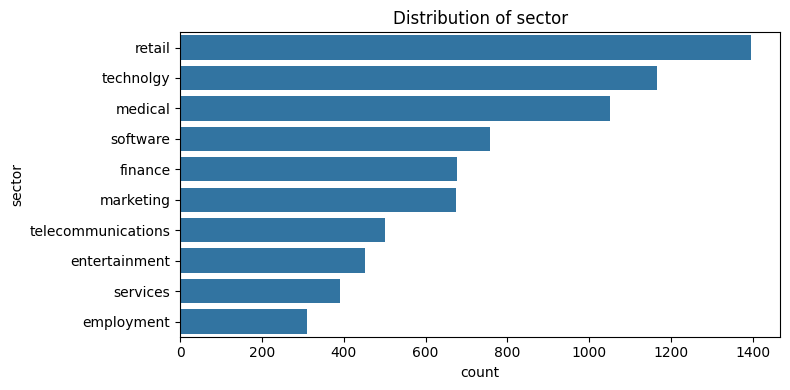


Value Counts for office_location:
 office_location
United States    6120
Korea             200
Panama            109
Belgium           109
Philipines         94
Italy              94
Kenya              92
Norway             91
Jordan             88
Japan              81
Poland             71
Brazil             61
China              58
Germany            55
Romania            52
Name: count, dtype: int64


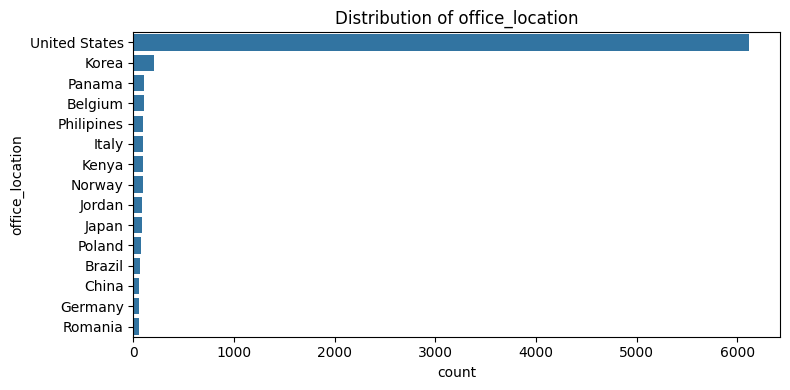


Value Counts for subsidiary_of:
 subsidiary_of
Acme Corporation    322
Sonron              283
Bubba Gump          177
Inity               176
Golddex             175
Massive Dynamic      98
Warephase            61
Name: count, dtype: int64


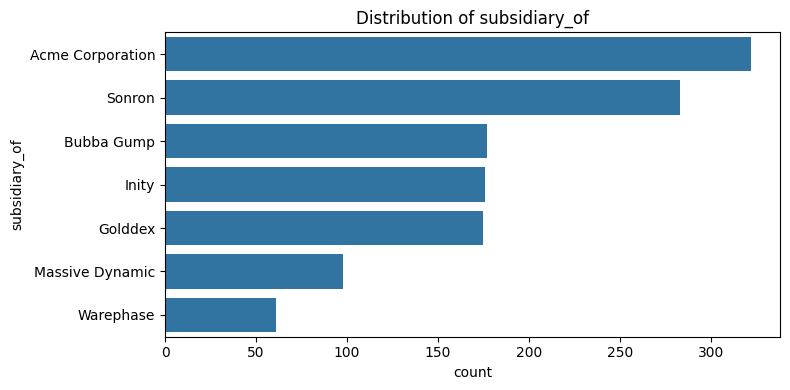


===== EDA Complete =====


In [5]:
perform_eda(all_df)

In [5]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    8800 non-null   object 
 1   sales_agent       8800 non-null   object 
 2   product           8800 non-null   object 
 3   account           7375 non-null   object 
 4   deal_stage        8800 non-null   object 
 5   engage_date       8300 non-null   object 
 6   close_date        6711 non-null   object 
 7   close_value       6711 non-null   float64
 8   manager           8800 non-null   object 
 9   regional_office   8800 non-null   object 
 10  series            7320 non-null   object 
 11  sales_price       7320 non-null   float64
 12  sector            7375 non-null   object 
 13  year_established  7375 non-null   float64
 14  revenue           7375 non-null   float64
 15  employees         7375 non-null   float64
 16  office_location   7375 non-null   object 


<Axes: xlabel='deal_stage'>

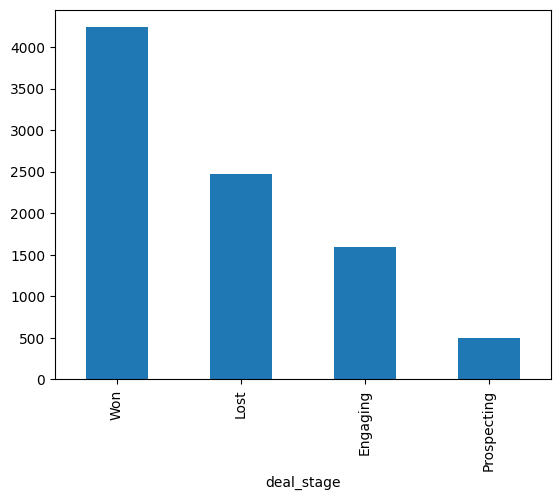

In [6]:
all_df['deal_stage'].value_counts().plot.bar()

In [ ]:
""" take away this sentence if you want to use the ordinal encoder. here you can use your custom order
# Specify the desired order of categories
custom_order = [['Engaging', 'Prospecting', 'Lost', 'Won']]

# Initialize the OrdinalEncoder with the custom order
ordinal_encoder = OrdinalEncoder(categories=custom_order)

# Fit and transform the column
all_df['deal_stage_encoded'] = ordinal_encoder.fit_transform(all_df[['deal_stage']])

# Verify the mapping
print("Custom Category Order:", ordinal_encoder.categories_)
print(all_df[['deal_stage', 'deal_stage_encoded']].head())


# checking for and correcting null values

In [6]:
# transform all categorical columns in X to numerical 

# Loop through all columns in the DataFrame
for col in all_df.select_dtypes(include=['object', 'category']).columns:
    # Initialize LabelEncoder
    le = LabelEncoder()
    # Fit and transform the column
    all_df[col] = le.fit_transform(all_df[col])
    
    # Optional: Display the mapping for each column
    #print(f"Mapping for column '{col}': {dict(zip(le.classes_, le.transform(le.classes_)))}") 

# Display the transformed DataFrame
print(all_df.head())


   opportunity_id  sales_agent  product  account  deal_stage  engage_date  \
0             345           20        2        8           3            0   
1            8556            6        4       37           3            1   
2            3540            6        6        8           3            1   
3            5674           20        1       10           3            1   
4            6274           29        1       33           3            1   

   close_date  close_value  manager  regional_office  series  sales_price  \
0           0       1054.0        2                0       1       1096.0   
1          10       4514.0        3                0       3          NaN   
2           6         50.0        3                0       2         55.0   
3           8        588.0        2                0       1        550.0   
4           1        517.0        5                2       1        550.0   

   sector  year_established  revenue  employees  office_location  \
0     

In [7]:
def nulls_summary_table(df):
    """
    Returns a summary table showing null value counts and percentage
    
    Parameters:
    df (DataFrame): Dataframe to check
    
    Returns:
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_pct']
    return null_values

nulls_summary_table(all_df)

,null_count,null_pct
opportunity_id,0,0.000000
sales_agent,0,0.000000
product,0,0.000000
account,0,0.000000
deal_stage,0,0.000000
engage_date,0,0.000000
close_date,0,0.000000
close_value,2089,0.237386
manager,0,0.000000
regional_office,0,0.000000


In [8]:
# impute the missing values with the mean using the sklearn.impute
# Create an imputer that will fill missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the DataFrame
all_df = pd.DataFrame(imputer.fit_transform(all_df), columns=all_df.columns)

# Display the DataFrame after imputation
print(all_df.head())

   opportunity_id  sales_agent  product  account  deal_stage  engage_date  \
0           345.0         20.0      2.0      8.0         3.0          0.0   
1          8556.0          6.0      4.0     37.0         3.0          1.0   
2          3540.0          6.0      6.0      8.0         3.0          1.0   
3          5674.0         20.0      1.0     10.0         3.0          1.0   
4          6274.0         29.0      1.0     33.0         3.0          1.0   

   close_date  close_value  manager  regional_office  series  sales_price  \
0         0.0       1054.0      2.0              0.0     1.0  1096.000000   
1        10.0       4514.0      3.0              0.0     3.0  1885.394126   
2         6.0         50.0      3.0              0.0     2.0    55.000000   
3         8.0        588.0      2.0              0.0     1.0   550.000000   
4         1.0        517.0      5.0              2.0     1.0   550.000000   

   sector  year_established  revenue  employees  office_location  \
0     

In [10]:
# encode the target variable
label_encoder = LabelEncoder()
all_df['deal_stage_encoded'] = label_encoder.fit_transform(all_df['deal_stage'])

In [11]:
# transform data into X and y variables
X = all_df[['sales_agent', 'product', 'account', 'manager',
            'regional_office', 'sales_price', 'sector','year_established', 
            'revenue', 'employees', 'office_location', 'subsidiary_of']]
y = all_df['deal_stage_encoded']

In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data, then transform the test data
X = scaler.fit_transform(X)

In [19]:
# or use MinMaxScaler()
scaler = MinMaxScaler()

# fit and transform the training data, then transform the test data
X = scaler.fit_transform(X)

In [20]:
# training the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [21]:
# using logistic regression
# Initialize and train logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.6272727272727273
Confusion Matrix:
[[185   0  43  98]
 [ 13   0   0 441]
 [ 16   0  70  28]
 [ 17   0   0 849]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.66       326
           1       0.00      0.00      0.00       454
           2       0.62      0.61      0.62       114
           3       0.60      0.98      0.74       866

    accuracy                           0.63      1760
   macro avg       0.50      0.54      0.51      1760
weighted avg       0.48      0.63      0.53      1760



C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\

In [22]:
# Initialize and train the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.5767045454545454
Confusion Matrix:
[[235   9  39  43]
 [  4 133   0 317]
 [ 53   5  51   5]
 [ 10 260   0 596]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       326
           1       0.33      0.29      0.31       454
           2       0.57      0.45      0.50       114
           3       0.62      0.69      0.65       866

    accuracy                           0.58      1760
   macro avg       0.57      0.54      0.55      1760
weighted avg       0.57      0.58      0.57      1760



In [23]:
# One-vs-Rest ROC-AUC score (if applicable)
roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.8029508758585613


In [24]:
# using the xg boost
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"accuracy is: {accuracy}")
print(classification_report(y_test, y_pred))


C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy is: 0.6034090909090909
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       326
           1       0.33      0.22      0.26       454
           2       0.60      0.58      0.59       114
           3       0.62      0.77      0.69       866

    accuracy                           0.60      1760
   macro avg       0.60      0.57      0.58      1760
weighted avg       0.59      0.60      0.59      1760



In [25]:
# One-vs-Rest ROC-AUC score (if applicable)
roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.8085615406116813
